## **Exam Scores Prediction**

The dataset contains test scores from three different subjects at a fictional public school. This dataset also contains variables about various personal and socio-economic factors for each student.

The goal is to provide an analysis on how several variables could affect a student's exam score and to predict future exam scores given those variables.

*Credits to the creator of the original dataset, **Mr. Royce Kimmons**, and to the uploaded dataset in **[Kaggle](https://www.kaggle.com/datasets/desalegngeb/students-exam-scores/data)***.

### **Data Description**

Column | Description |
-----|-----|
Gender | Gender of the student (male/female) |
EthnicGroup | Ethnic group of the student (group A to E) |
ParentEduc | Parent(s) education background (from some_highschool to master's degree) |
LunchType | School lunch type (standard or free/reduced) |
TestPrep | Test preparation course followed (completed or none) |
ParentMaritalStatus | Parent(s) marital status (married/single/widowed/divorced) |
PracticeSport | How often the student practice sport (never/sometimes/regularly) |
IsFirstChild | If the first child in the family or not (yes/no) |
NrSiblings | Number of siblings the student has (0 to 7) |
TransportMeans | Means of transport to school (schoolbus/private) |
WklyStudyHours | Weekly self-study hours(less than 5hrs, between 5 and 10 hrs, more than 10 hours) |
MathScore | Math test score (0-100) |
ReadingScore | Reading test score (0-100) |
WritingScore | Writing test score (0-100) |

### **Preparation**

In [100]:
## For data manipulation

import numpy as np
import pandas as pd

## For data visualization

import matplotlib.pyplot as plt
import seaborn as sns

## For displaying all columns in the dataframe

pd.set_option('display.max_columns', None)

## For statistical tests

from scipy import stats

## For data modelling

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA

## For metrics and helpful functions

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, make_scorer, mean_squared_error
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

## For saving models

import pickle

## Miscellaneous

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### **DATA CLEANING**

In [3]:
## Load the dataset

df = pd.read_csv("D:\Documents\CSV Datasets\Student Marks\Expanded_data_with_more_features.csv")

df.head(10)

,Unnamed: 0,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75
5,5,female,group B,associate's degree,standard,none,married,regularly,yes,1.0,school_bus,5 - 10,73,84,79
6,6,female,group B,some college,standard,completed,widowed,never,no,1.0,private,5 - 10,85,93,89
7,7,male,group B,some college,free/reduced,none,married,sometimes,yes,1.0,private,> 10,41,43,39
8,8,male,group D,high school,free/reduced,completed,single,sometimes,no,3.0,private,> 10,65,64,68
9,9,female,group B,high school,free/reduced,none,married,regularly,yes,NaN,private,< 5,37,59,50


In [4]:
## Check the size of the dataset

print(df.shape)

(30641, 15)


The dataset contains **`30,641`** rows and **`15`** columns.

In [5]:
## Check information about the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           30641 non-null  int64  
 1   Gender               30641 non-null  object 
 2   EthnicGroup          28801 non-null  object 
 3   ParentEduc           28796 non-null  object 
 4   LunchType            30641 non-null  object 
 5   TestPrep             28811 non-null  object 
 6   ParentMaritalStatus  29451 non-null  object 
 7   PracticeSport        30010 non-null  object 
 8   IsFirstChild         29737 non-null  object 
 9   NrSiblings           29069 non-null  float64
 10  TransportMeans       27507 non-null  object 
 11  WklyStudyHours       29686 non-null  object 
 12  MathScore            30641 non-null  int64  
 13  ReadingScore         30641 non-null  int64  
 14  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(4), object(10)


#### **Check for *null* values**

In [6]:
## Check the number of null values for each variable in the dataset

for col in df.columns:
    print('Null Values for column {} is {}%'.format(col, np.round(df[col].isnull().sum()*100 / len(df[col])),2))

Null Values for column Unnamed: 0 is 0.0%
Null Values for column Gender is 0.0%
Null Values for column EthnicGroup is 6.0%
Null Values for column ParentEduc is 6.0%
Null Values for column LunchType is 0.0%
Null Values for column TestPrep is 6.0%
Null Values for column ParentMaritalStatus is 4.0%
Null Values for column PracticeSport is 2.0%
Null Values for column IsFirstChild is 3.0%
Null Values for column NrSiblings is 5.0%
Null Values for column TransportMeans is 10.0%
Null Values for column WklyStudyHours is 3.0%
Null Values for column MathScore is 0.0%
Null Values for column ReadingScore is 0.0%
Null Values for column WritingScore is 0.0%


Some columns have ***null*** values. However, we will check the best method to handle those missing values.

Also, the Dtype for the column **NrSiblings** is ***float64***. This is not the correct datatype because the column contains *discrete* variables. The datatype for this column should be changed to ***int64***.

#### **Converting datatypes, renaming columns, and removing unnecessary columns**

In [7]:
## Changing the datatype of 'NrSiblings' into int64

df['NrSiblings'] = pd.to_numeric(df['NrSiblings'], downcast='integer', errors='coerce')
df['NrSiblings'] = df['NrSiblings'].astype('Int64')

df['NrSiblings'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 30641 entries, 0 to 30640
Series name: NrSiblings
Non-Null Count  Dtype
--------------  -----
29069 non-null  Int64
dtypes: Int64(1)
memory usage: 269.4 KB


In [8]:
## Removed the 'Unnamed' column

df = df.drop('Unnamed: 0', axis=1)

In [9]:
## Change column names to 'snake_case'

df.rename(columns={'Gender':'gender',
                   'EthnicGroup':'ethnic_group',
                   'ParentEduc':'parents_education',
                   'LunchType':'lunch_type',
                   'TestPrep':'test_preparation',
                   'ParentMaritalStatus':'parent_marital_status',
                   'PracticeSport':'practice_sports',
                   'IsFirstChild':'is_first_child',
                   'NrSiblings':'number_of_siblings',
                   'TransportMeans':'transport_means',
                   'WklyStudyHours':'weekly_study_hours',
                   'MathScore':'math_score',
                   'ReadingScore':'reading_score',
                   'WritingScore':'writing_score'}, inplace=True)

df.head()

,gender,ethnic_group,parents_education,lunch_type,test_preparation,parent_marital_status,practice_sports,is_first_child,number_of_siblings,transport_means,weekly_study_hours,math_score,reading_score,writing_score
0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3,school_bus,< 5,71,71,74
1,female,group C,some college,standard,NaN,married,sometimes,yes,0,NaN,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4,school_bus,< 5,87,93,91
3,male,group A,associate's degree,free/reduced,none,married,never,no,1,NaN,5 - 10,45,56,42
4,male,group C,some college,standard,none,married,sometimes,yes,0,school_bus,5 - 10,76,78,75


### **Handling Missing Data**

The method for handling missing data will be either by ***removing the null values***, or by ***imputation***.

#### **Method 1A: Removing *null* values in the dataset**

In [10]:
## Drop null values from all columns

df1 = df.dropna(axis=0)

df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19243 entries, 2 to 30640
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   gender                 19243 non-null  object
 1   ethnic_group           19243 non-null  object
 2   parents_education      19243 non-null  object
 3   lunch_type             19243 non-null  object
 4   test_preparation       19243 non-null  object
 5   parent_marital_status  19243 non-null  object
 6   practice_sports        19243 non-null  object
 7   is_first_child         19243 non-null  object
 8   number_of_siblings     19243 non-null  Int64 
 9   transport_means        19243 non-null  object
 10  weekly_study_hours     19243 non-null  object
 11  math_score             19243 non-null  int64 
 12  reading_score          19243 non-null  int64 
 13  writing_score          19243 non-null  int64 
dtypes: Int64(1), int64(3), object(10)
memory usage: 2.2+ MB


After removing all the *null* values in the dataset, we are left with **19,243** rows, which is 62.80% of the original dataset.

#### **Method 1B: Removing *null* values from specified columns**

To avoid over-representation of certain data, the limit for the number of *null* values in which imputation will be used will be set to **5.0%** of the total number of data in a certain column.

The columns **EthnicGroup**, **ParentEduc**, **TestPrep**, and **TransportMeans** contains *null* values that are more than 5.0% of the total number of data in their respective column. We will remove *null* values from this columns before proceeding with imputation.

In [11]:
## Drop null values from selected columns

df1b = df.copy()

df1b = df1b.dropna(subset=['ethnic_group','parents_education','test_preparation','number_of_siblings','transport_means'], axis=0)

df1b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21721 entries, 2 to 30640
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   gender                 21721 non-null  object
 1   ethnic_group           21721 non-null  object
 2   parents_education      21721 non-null  object
 3   lunch_type             21721 non-null  object
 4   test_preparation       21721 non-null  object
 5   parent_marital_status  20883 non-null  object
 6   practice_sports        21298 non-null  object
 7   is_first_child         21094 non-null  object
 8   number_of_siblings     21721 non-null  Int64 
 9   transport_means        21721 non-null  object
 10  weekly_study_hours     21038 non-null  object
 11  math_score             21721 non-null  int64 
 12  reading_score          21721 non-null  int64 
 13  writing_score          21721 non-null  int64 
dtypes: Int64(1), int64(3), object(10)
memory usage: 2.5+ MB


#### **Method 2: Use *Mode Imputation***

The values for the columns with *null* data are contains categorical and binary data. To avoid over-representing certain data, we set a limit to null values equal to or less than **5.0%** of the total number of data in their respective column. The columns with null values that exceeded the limit had all their null values dropped.

In [12]:
## Mode imputation for categorical columns

df1b['parent_marital_status'] = df1b['parent_marital_status'].fillna(df1b['parent_marital_status'].mode()[0])
df1b['practice_sports'] = df1b['practice_sports'].fillna(df1b['practice_sports'].mode()[0])
df1b['weekly_study_hours'] = df1b['weekly_study_hours'].fillna(df1b['weekly_study_hours'].mode()[0])

## Mode imputation for binary columns

df1b['is_first_child'] = df1b['is_first_child'].fillna(df1b['is_first_child'].mode()[0])

df1b.isnull().sum()

gender                   0
ethnic_group             0
parents_education        0
lunch_type               0
test_preparation         0
parent_marital_status    0
practice_sports          0
is_first_child           0
number_of_siblings       0
transport_means          0
weekly_study_hours       0
math_score               0
reading_score            0
writing_score            0
dtype: int64

In [13]:
df1b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21721 entries, 2 to 30640
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   gender                 21721 non-null  object
 1   ethnic_group           21721 non-null  object
 2   parents_education      21721 non-null  object
 3   lunch_type             21721 non-null  object
 4   test_preparation       21721 non-null  object
 5   parent_marital_status  21721 non-null  object
 6   practice_sports        21721 non-null  object
 7   is_first_child         21721 non-null  object
 8   number_of_siblings     21721 non-null  Int64 
 9   transport_means        21721 non-null  object
 10  weekly_study_hours     21721 non-null  object
 11  math_score             21721 non-null  int64 
 12  reading_score          21721 non-null  int64 
 13  writing_score          21721 non-null  int64 
dtypes: Int64(1), int64(3), object(10)
memory usage: 2.5+ MB


#### **Compare the descriptive statistics of the two datasets**

In [14]:
descriptive_stats = pd.concat([df.describe(), df1b.describe()], axis=1, keys=['Dataset with Removed Null Values','Dataset with Mode Imputation'])

descriptive_stats

Dataset with Removed Null Values                              \
                    number_of_siblings    math_score reading_score   
count                          29069.0  30641.000000  30641.000000   
mean                          2.145894     66.558402     69.377533   
std                           1.458242     15.361616     14.758952   
min                                0.0      0.000000     10.000000   
25%                                1.0     56.000000     59.000000   
50%                                2.0     67.000000     70.000000   
75%                                3.0     78.000000     80.000000   
max                                7.0    100.000000    100.000000   

                    Dataset with Mode Imputation                              \
      writing_score           number_of_siblings    math_score reading_score   
count  30641.000000                      21721.0  21721.000000  21721.000000   
mean      68.418622                     2.140785     66.589844     69.467152   
std       15.443525                     1.447413     15.382437     14.787346   
min        4.000000                          0.0      0.000000     10.000000   
25%       58.000000                          1.0     56.000000     59.000000   
50%       69.000000                          2.0     67.000000     70.000000   
75%       79.000000                          3.0     78.000000     80.000000   
max      100.000000                          7.0    100.000000    100.000000   

                     
      writing_score  
count  21721.000000  
mean      68.534736  
std       15.488860  
min        4.000000  
25%       58.000000  
50%       69.000000  
75%       79.000000  
max      100.000000

Based on the descriptive statistics from the resulting datasets from the two methods, the statistic values for the dataset with mode imputations applied varies from the dataset with all null values removed by a very small amount (less than 1.00).

With this result, we will proceed on using the dataset obtained from mode imputation as it contains more data compared to the dataset with all null values removed.

### **EXPLORATORY DATA ANALYSIS (EDA)**

#### **1. Gender**

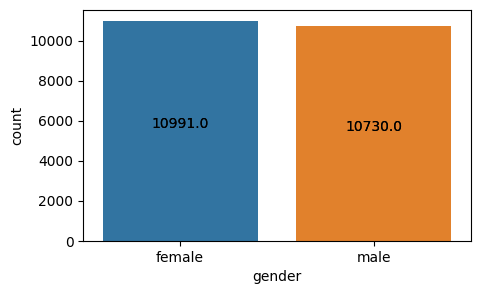

math_score        reading_score        writing_score       
             mean median          mean median          mean median
gender                                                            
female  64.162861   64.0     72.968247   73.0     72.980893   73.0
male    69.075862   69.0     65.880895   66.0     63.980429   64.0

In [15]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='gender')

tag = sns.countplot(data=df1b, x='gender')

for i in tag.patches:
    tag.annotate(f'{i.get_height()}', (i.get_x() + i.get_width() / 2., i.get_height() / 2), ha='center', va='bottom')

plt.show()

df1b.groupby(['gender'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

- There are more female than male students. The difference is quite small as the female students are only 261 (1.20%) more than the male students.
- Male students generally score higher in Math, while female students generally score higher in Reading and Writing.

#### **2. Ethnic Group**

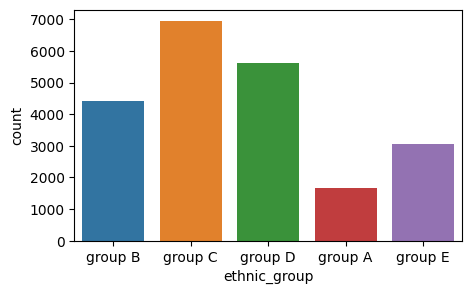

math_score        reading_score        writing_score       
                   mean median          mean median          mean median
ethnic_group                                                            
group A       62.974699   64.0     66.709639   66.0     65.120482   65.0
group B       63.536916   64.0     67.347934   68.0     65.994581   66.0
group C       64.735345   65.0     68.518391   69.0     67.122845   67.0
group D       67.669339   68.0     70.515945   71.0     71.032425   71.0
group E       75.210526   76.0     74.266100   75.0     72.694671   73.0

In [16]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='ethnic_group')

plt.show()

df1b.groupby(['ethnic_group'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

- Students from **Ethnic Group E** have the highest scores from the 3 subjects.
- The hierarchy of students based on exam scores is the same from all the 3 subjects - 1. group E, 2. group D, 3. group C,  4. group B, 5. group A (from highest to lowest). This is true for both the mean and median scores.
- There seems to be a clear correlation between the ethnic group and the exam scores.

#### **3. Parent's Educational Background**

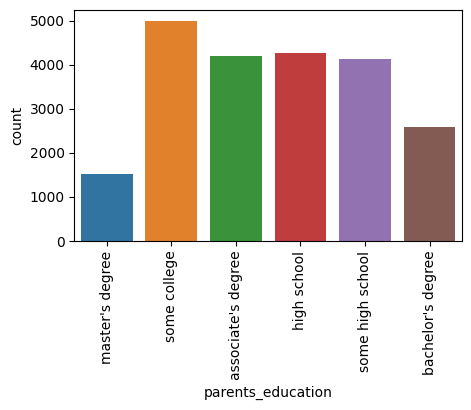

math_score        writing_score        reading_score       
                         mean median          mean median          mean median
parents_education                                                             
associate's degree  68.477651   69.0     70.403947   71.0     71.159534   71.0
bachelor's degree   70.691892   71.0     73.737452   74.0     73.440154   74.0
high school         64.262652   64.0     65.410965   66.0     67.183693   68.0
master's degree     72.284500   73.0     76.335513   77.0     75.785481   77.0
some college        66.507113   66.0     68.603086   69.0     69.285314   70.0
some high school    62.498429   63.0     63.634276   64.0     65.499154   65.0

In [17]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='parents_education')
plt.xticks(rotation=90)

plt.show()

df1b.groupby(['parents_education'])[['math_score','writing_score','reading_score']].agg(['mean','median'])

- Students who have parents that obtained Master's Degree scored the highest in all three exams.
- The hierarchy of students based on exam scores is the same for all the 3 subjects- 1. master's degree, 2. bachelor's degree, 3. associate's degree,  4. some college, 5. some highschool (from highest to lowest). This is true for both the mean and median scores.
- There is a correlation between the exam scores of the students and their parent's highest educational attainment. This is because students with parents who have a degree scored higher than students who have parents without a degree.

#### **4. Lunch Type**

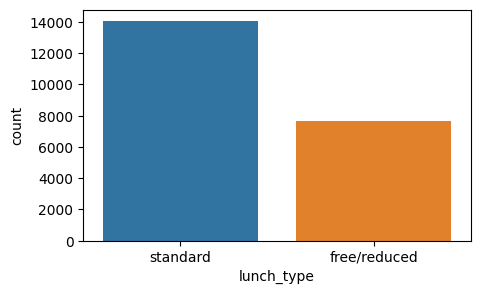

math_score        reading_score        writing_score       
                   mean median          mean median          mean median
lunch_type                                                              
free/reduced  58.879832   59.0     64.245577   64.0     62.746298   63.0
standard      70.765507   71.0     72.295103   73.0     71.669695   72.0

In [18]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='lunch_type')

plt.show()

df1b.groupby(['lunch_type'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

- Students who have standard lunch type scored higher than the students with free/reduced lunch type. The difference is quite noticeable especially for the Math exam.
- There are more students that have standard lunch type.
- The type of lunch a student has seems to affect their exam scores for the 3 subjects. It seems like student who enjoyed better food tend to perform better in exams.

#### **5. Test Preparation**

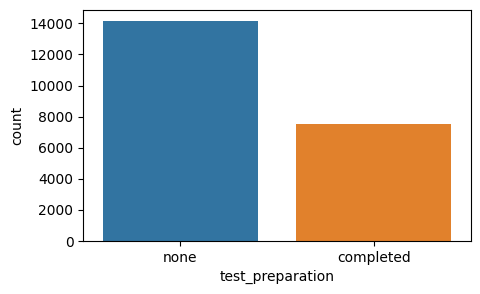

math_score        reading_score        writing_score       
                       mean median          mean median          mean median
test_preparation                                                            
completed         69.681842   70.0     73.863950   74.0     74.860499   75.0
none              64.947840   65.0     67.132234   67.0     65.175442   65.0

In [19]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='test_preparation')

plt.show()

df1b.groupby(['test_preparation'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

- Students who prepared for the exam better for all the subjects compared to students with no preparation.
- However, there are more students who do not prepare for the exams, as shown in the plot.

#### **6. Parent's Marital Status**

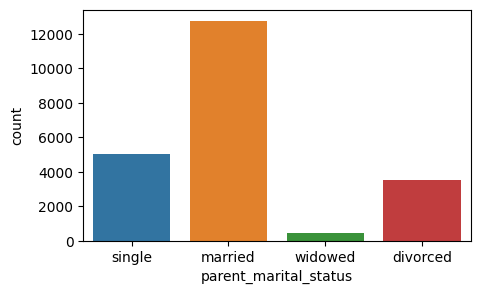

math_score        reading_score        writing_score  \
                            mean median          mean median          mean   
parent_marital_status                                                        
divorced               66.652371   67.0     69.700085   70.0     68.879012   
married                66.666536   67.0     69.429912   70.0     68.447669   
single                 66.246203   66.0     69.320344   70.0     68.446243   
widowed                67.849515   69.0     70.415049   71.0     69.368932   

                              
                      median  
parent_marital_status         
divorced                69.0  
married                 69.0  
single                  69.0  
widowed                 70.0

In [20]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='parent_marital_status')

plt.show()

df1b.groupby(['parent_marital_status'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

- Students who have widowed parents scored better that the other students.
- The difference in scores for all the variables is very small. There seems to be little to no correlation between the exam scores and the marital status of the student's parents.

#### **7. Practice Sports**

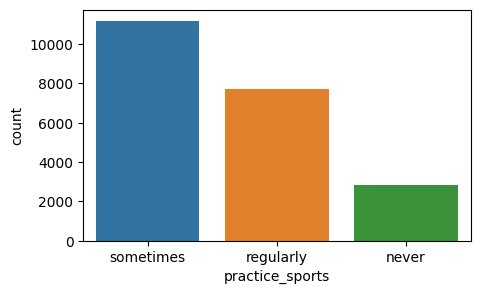

math_score        reading_score        writing_score       
                      mean median          mean median          mean median
practice_sports                                                            
never            64.487848   65.0     68.651638   69.0     66.876717   67.0
regularly        67.677549   68.0     69.946020   70.0     69.638918   70.0
sometimes        66.375916   66.0     69.345096   70.0     68.196891   68.0

In [21]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='practice_sports')

plt.show()

df1b.groupby(['practice_sports'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

- Students who regularly practice sports scored higher than other students.
- The difference between the mean and median scores for students who regularly practice sports and those who sometime practice it is very small. However, there is quite a noticeable difference from the results of the two variables compared to the exam scores obtained from students who never practice sports. This findings is true for Math and Writing score, but not for the Reading score.
- There seems to be a little correlation between the exam scores and whether a student practice sports or not. This is true for Math and Writing scores.

#### **8. Is First Child?**

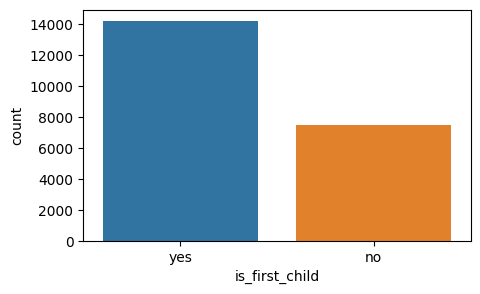

math_score        reading_score        writing_score       
                     mean median          mean median          mean median
is_first_child                                                            
no              66.418924   67.0     69.336848   70.0     68.483785   69.0
yes             66.679857   67.0     69.535775   70.0     68.561569   69.0

In [22]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='is_first_child')

plt.show()

df1b.groupby(['is_first_child'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

- The exam scores for all three subjects between students who are first child and those who are not is quite similar. This means that whether a student is a first child or not does not contribute to their exam scores.

#### **9. Number of Siblings**

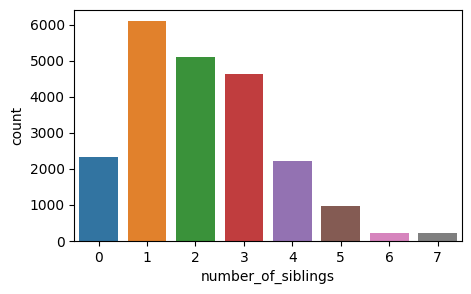

math_score        reading_score        writing_score       
                         mean median          mean median          mean median
number_of_siblings                                                            
0                   66.673744   67.0     69.643847   70.0     68.766031   69.0
1                   66.474546   67.0     69.331806   70.0     68.337698   69.0
2                   66.568543   67.0     69.459698   70.0     68.540498   69.0
3                   66.717838   67.0     69.512649   70.0     68.684757   69.0
4                   66.341353   66.0     69.462097   70.0     68.474807   69.0
5                   66.968880   67.0     69.680498   70.0     68.557054   69.0
6                   66.717073   66.0     68.726829   70.0     67.643902   68.0
7                   67.471154   69.0     70.447115   71.0     69.687500   70.0

In [23]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='number_of_siblings')

plt.show()

df1b.groupby(['number_of_siblings'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

- Whether a students have more siblings or not does not affect their exam scores, as shown in the aggregate results. The mean and median of the exam results have very little difference between each variables.

#### **10. Transport Means**

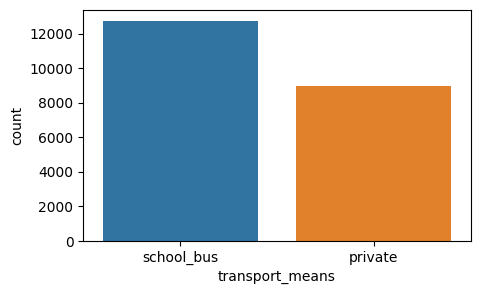

math_score        reading_score        writing_score       
                      mean median          mean median          mean median
transport_means                                                            
private          66.500947   67.0     69.469401   70.0     68.530487   69.0
school_bus       66.652392   67.0     69.465569   70.0     68.537725   69.0

In [24]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='transport_means')

plt.show()

df1b.groupby(['transport_means'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

- There is also no correlation between the exam scores and the student's means of transportation. The mean and median scores for all the three exams scores are almost similar for each variable.

#### **11. Weekly Study Hours**

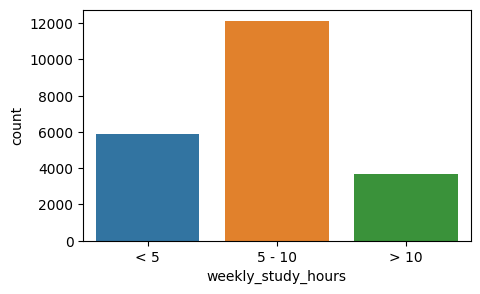

,math_score,reading_score,writing_score
weekly_study_hours,,,
5 - 10,66.904703,69.736183,68.760728
< 5,64.601423,68.323674,67.255042
> 10,68.740147,70.413428,69.841533


In [25]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='weekly_study_hours')

plt.show()

df1b.groupby(['weekly_study_hours'])[['math_score','reading_score','writing_score']].agg('mean','median')

- Students who studied more than 10 hours per week scored higher for all three exams.
- There is a correlation between exam scores and the weekly study hours of a student, as students who spent more time studying tend to get higher scores, and student who spent the least time studying scored the lowest.
- As shown in the plot, most students study for 5 to 10 hours per week.

Before proceeding with the Model Building, we will exclude the variables that has no correlation with the exam scores. These variables are `is_first_child`, `number_of_siblings`, and `transport_means`.

In [26]:
## Drop 'is_first_child', 'number_of_siblings', and 'transport_means' columns

df1b = df1b.drop(columns=['is_first_child','number_of_siblings','transport_means'], axis=1)

### **MODEL BUILDING**

### **XGBoost Model**

In [27]:
## Create a copy of the dataset to be encoded

df1b_enc = df1b.copy()

df1b_enc.head()

,gender,ethnic_group,parents_education,lunch_type,test_preparation,parent_marital_status,practice_sports,weekly_study_hours,math_score,reading_score,writing_score
2,female,group B,master's degree,standard,none,single,sometimes,< 5,87,93,91
4,male,group C,some college,standard,none,married,sometimes,5 - 10,76,78,75
5,female,group B,associate's degree,standard,none,married,regularly,5 - 10,73,84,79
6,female,group B,some college,standard,completed,widowed,never,5 - 10,85,93,89
7,male,group B,some college,free/reduced,none,married,sometimes,> 10,41,43,39


For the new dataset, we will encode categorical variables.

We will use **dummy encode** the following columns: 
- `ethnic_group`, `parents_education`, `parent_marital_status`, `practice_sports`, and `weekly_study_hours`

And convert the following columns into **binary**:
- `gender`, `lunch_type`, and `test_preparation`

In [28]:
## Define variables to dummy encode

columns_to_encode = ['ethnic_group','parents_education','parent_marital_status','practice_sports','weekly_study_hours']

for col in columns_to_encode:
    df1b_enc = pd.get_dummies(data=df1b_enc, columns=[col], drop_first=True, dtype=int)
    
## Convert selected variables into binary
    
df1b_enc['gender'] = np.where(df1b_enc['gender']=='male',1,0)
df1b_enc['lunch_type'] = np.where(df1b_enc['lunch_type']=='standard',1,0)
df1b_enc['test_preparation'] = np.where(df1b_enc['test_preparation']=='completed',1,0)

## Replace characters that could cause errors

df1b_enc.columns = df1b_enc.columns.str.replace(' ', '_').str.replace("'","").str.replace('>','_more_than_').str.replace('<','_less_than_')
    
df1b_enc.head()

,gender,lunch_type,test_preparation,math_score,reading_score,writing_score,ethnic_group_group_B,ethnic_group_group_C,ethnic_group_group_D,ethnic_group_group_E,parents_education_bachelors_degree,parents_education_high_school,parents_education_masters_degree,parents_education_some_college,parents_education_some_high_school,parent_marital_status_married,parent_marital_status_single,parent_marital_status_widowed,practice_sports_regularly,practice_sports_sometimes,weekly_study_hours__less_than__5,weekly_study_hours__more_than__10
2,0,1,0,87,93,91,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0
4,1,1,0,76,78,75,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0
5,0,1,0,73,84,79,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
6,0,1,1,85,93,89,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
7,1,0,0,41,43,39,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1


#### **Split the data**

In [104]:
## Define the target variable

target_var = df1b_enc[['math_score','reading_score','writing_score']]

target_math = target_var['math_score']
target_reading = target_var['reading_score']
target_writing = target_var['writing_score']

## Define the predictor variable

predictor_var = df1b_enc.drop(['math_score','reading_score','writing_score'], axis=1)

## Split into train and test sets

X_train, X_test, y_math_train, y_math_test, y_reading_train, y_reading_test, y_writing_train, y_writing_test = train_test_split(predictor_var, target_math, 
                                                                                                                                target_reading, target_writing,
                                                                                                                                test_size=0.25, random_state=42)

#### **Cross-validated hyperparameter tuning**

In [59]:
## Create XGBoost models for each test scores

xgb_math = XGBRegressor()
xgb_reading = XGBRegressor()
xgb_writing = XGBRegressor()

## Hyperparameter tuning with GridSearch

params = {'max_depth': [4,5,6,7,8], 
          'min_child_weight': [1,2,3,4,5],
          'learning_rate': [0.1, 0.2, 0.3],
          'n_estimators': [75, 100, 125]
          }

scores = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

grid_math = GridSearchCV(xgb_math, param_grid=params, cv=5, scoring=scores)
grid_reading = GridSearchCV(xgb_reading, param_grid=params, cv=5, scoring=scores)
grid_writing = GridSearchCV(xgb_writing, param_grid=params, cv=5, scoring=scores)

grid_math.fit(X_train, y_math_train)
grid_reading.fit(X_train, y_reading_train)
grid_writing.fit(X_train, y_reading_train)

## Obtain the best hyperparameters

math_best_params = grid_math.best_params_
reading_best_params = grid_reading.best_params_
writing_best_params = grid_writing.best_params_


In [106]:
## Perform cross-validation and get predicted values

math_preds = cross_val_predict(grid_math.best_estimator_, X_train, y_math_train, cv=5)
reading_preds = cross_val_predict(grid_reading.best_estimator_, X_train, y_math_train, cv=5)
writing_preds = cross_val_predict(grid_writing.best_estimator_, X_train, y_math_train, cv=5)

In [107]:
## Print RMSE values

rmse_math = np.sqrt(mean_squared_error(y_math_train, math_preds))
rmse_reading = np.sqrt(mean_squared_error(y_reading_train, reading_preds))
rmse_writing = np.sqrt(mean_squared_error(y_writing_train, writing_preds))

print('RMSE Value for Math Scores:', rmse_math)
print('RMSE Value for Reading Scores:', rmse_reading)
print('RMSE Value for Writing Scores:', rmse_writing)

RMSE Value for Math Scores: 12.99992262815943
RMSE Value for Reading Scores: 14.743953052786756
RMSE Value for Writing Scores: 14.903747054828024


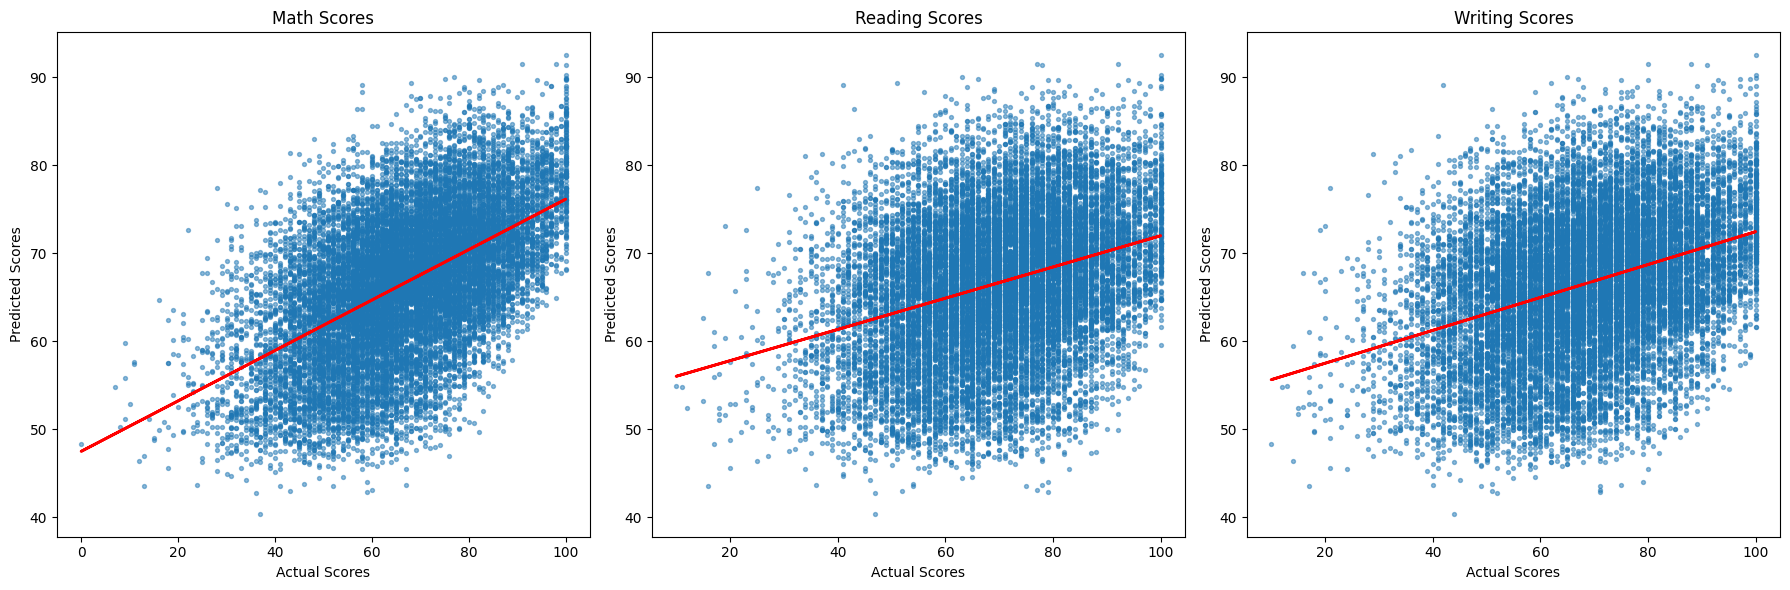

In [108]:
## Create a scatterplot to visualize actual versus predicted scores

test_scores = {'Math':(y_math_train, math_preds),
               'Reading':(y_reading_train, reading_preds),
               'Writing':(y_writing_train, writing_preds)}

plt.figure(figsize=(18,6))

for i, (subj_score_name,(actual_score, predicted_score)) in enumerate(test_scores.items()):
    plt.subplot(1,3, i+1)
    plt.scatter(actual_score, predicted_score, s=8, alpha=0.5)
    plt.title(f'{subj_score_name} Scores')
    plt.xlabel("Actual Scores")
    plt.ylabel("Predicted Scores")
    lr = LinearRegression()
    lr.fit(actual_score.values.reshape(-1,1), predicted_score)
    plt.plot(actual_score, lr.predict(actual_score.values.reshape(-1,1)), color='red', linewidth=2)
    
plt.tight_layout()
plt.show()

The **Root Mean Square Error (RMSE)** for the three exam scores are the following:
- Math Scores: 13.000
- Reading Scores: 14.744
- Writing Scores: 14.904

Which means that the predicted scores for each subject deviate from the actual scores by the RMSE value of that respective subject. It means that the predicted values for Math Scores are off by an average of 13.000 points from the actual values, 14.744 points for Reading Scores, and 14.984 points for Writing Scores.

These are high values of errors considering we only have values of 0 to 100 for each exam scores.

The results is also backed up by the scatterplots for each subjects, which shows that many points are scattered far from the best fit line. Which indicates a weak relationship between variables.

In [109]:
## Create a table showing comparison between actual and predicted values of test results

comparison_table = pd.DataFrame({'Actual Math Score': y_math_train.values,
                                 'Predicted Math Score': math_preds,
                                 'Actual Reading Score': y_reading_train.values,
                                 'Predicted Reading Score': reading_preds,
                                 'Actual Writing Score': y_writing_train.values,
                                 'Predicted Writing Score': writing_preds
                                 })

comparison_table.head()

,Actual Math Score,Predicted Math Score,Actual Reading Score,Predicted Reading Score,Actual Writing Score,Predicted Writing Score
0,69,70.787338,69,70.787338,70,70.787338
1,90,69.141335,80,69.141335,81,69.141335
2,79,77.691803,78,77.691803,70,77.691803
3,55,68.424431,58,68.424431,60,68.424431
4,40,59.363270,49,59.363270,53,59.363270


The predicted values showed huge variance from the actual scores for all subjects.

### **Feature Importance**

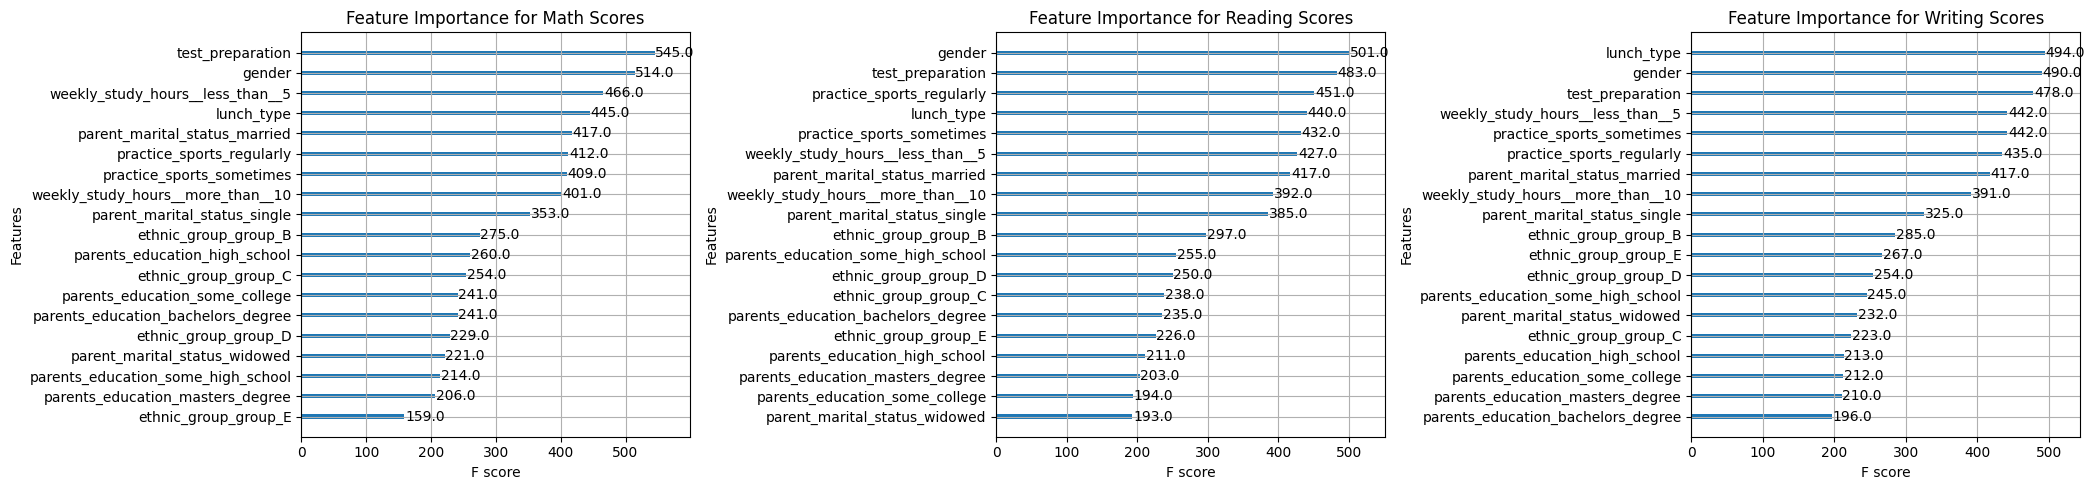

In [119]:
## Fit the models for each scores

xgb_math.fit(predictor_var, target_math)
xgb_reading.fit(predictor_var, target_reading)
xgb_writing.fit(predictor_var, target_writing)

## Plot feature importance for each scores

fig, ax = plt.subplots(1,3, figsize=(21,5))

xgb.plot_importance(xgb_math, importance_type='weight', title='Feature Importance for Math Scores', ax=ax[0])
xgb.plot_importance(xgb_reading, importance_type='weight', title='Feature Importance for Reading Scores', ax=ax[1])
xgb.plot_importance(xgb_writing, importance_type='weight', title='Feature Importance for Writing Scores', ax=ax[2])

plt.tight_layout()
plt.show()

The three exam scores showed different feature importances. For the Math Scores, it seems like test preparation, gender, and number of study hours have the most weight. For the Reading Scores, gender, test preparation, and whether a student practice sports or not played the biggest role. For the Writing Scores, the lunch type, gender, and test preparation have the most weight.

### **CONCLUSION**

- The model could use a lot of improvement in prediction as it returned a high value of error.
- There are variables that appear the most in the feature importance, these variables are `test_preparation`, `gender`, and `lunch_type`, `weekly_study_hours`, and `practice_sports`. The variable `test_preparation` could be an obvious variable to appear on the top of the feature importance. However, variables such as `gender` appeared on the top 3 feature importance for the three exams, which is quite questionable.
- In order to increase the model's performance, more sample data should be provided to increase the predictive ability of the model.